# Задача Римана о распаде разрыва



In [1]:
import numpy as np
import matplotlib.pyplot as plt

Параметры (все расчеты ведутся в СИ)

In [2]:
L           = 10     # м
NX          = 100
tau_init    = 1e-5   # с
CFL_max     = 0.01
time_output = 0.015  # с
time_end    = 0.02   # с
gamma       = 5 / 3

# начальные условия
u_L     = 0             # м / с
rho_L   = 13            # кг / м^3
P_L     = 10 * 10 ** 5  # Па
gamma_L = gamma

u_R     = 0             # м / с
rho_R   = 1.3           # кг / м^3
P_R     = 1 * 10 ** 5   # Па
gamma_R = gamma

Генерация сетки

In [3]:
x_grid, h_grid = np.linspace(-L, L, NX, retstep=True)
print(f"h_grid = {h_grid}")
x_grid

h_grid = 0.20202020202020202


array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818,  -7.97979798,  -7.77777778,
        -7.57575758,  -7.37373737,  -7.17171717,  -6.96969697,
        -6.76767677,  -6.56565657,  -6.36363636,  -6.16161616,
        -5.95959596,  -5.75757576,  -5.55555556,  -5.35353535,
        -5.15151515,  -4.94949495,  -4.74747475,  -4.54545455,
        -4.34343434,  -4.14141414,  -3.93939394,  -3.73737374,
        -3.53535354,  -3.33333333,  -3.13131313,  -2.92929293,
        -2.72727273,  -2.52525253,  -2.32323232,  -2.12121212,
        -1.91919192,  -1.71717172,  -1.51515152,  -1.31313131,
        -1.11111111,  -0.90909091,  -0.70707071,  -0.50505051,
        -0.3030303 ,  -0.1010101 ,   0.1010101 ,   0.3030303 ,
         0.50505051,   0.70707071,   0.90909091,   1.11111111,
         1.31313131,   1.51515152,   1.71717172,   1.91919192,
         2.12121212,   2.32323232,   2.52525253,   2.72

Функции

In [4]:
# Расчет матриц
def Omega_transposed(v_i, gamma):
    # v_i = [rho, u, e] - значения примитивных переменных в точке x_i
    u = v_i[1]
    e = v_i[2]
    c = c_velocity(e, gamma)
    return np.array([
        [ -u * c,  c, gamma - 1],
        [-c ** 2,  0, gamma - 1],
        [  u * c, -c, gamma - 1]
    ])

def Omega_transposed_inverse(v_i, gamma):
    # v_i = [rho, u, e] - значения примитивных переменных в точке x_i
    u = v_i[1]
    e = v_i[2]
    c = c_velocity(e, gamma)
    return np.array([
        [      1 / (2 * c ** 2),     -2 / (2 * c ** 2),       1 / (2 * c ** 2)],
        [(u + c) / (2 * c ** 2), -2 * u / (2 * c ** 2), (u - c) / (2 * c ** 2)],
        [ 1 / (2 * (gamma - 1)),                     0,  1 / (2 * (gamma - 1))]
    ])

def Lambda_abs(v_i, gamma):
    # v_i = [rho, u, e] - значения примитивных переменных в точке x_i
    u = v_i[1]
    e = v_i[2]
    c = c_velocity(e, gamma)
    return np.array([
        [np.abs(u + c),         0,             0],
        [            0, np.abs(u),             0],
        [            0,         0, np.abs(u - c)]
    ])

def A_matrix(v_i, gamma):
    # v_i = [rho, u, e] - значения примитивных переменных в точке x_i
    rho = v_i[0]
    u = v_i[1]
    e = v_i[2]
    return np.array([
        [             0,         1,        0],
        [       -u ** 2,     2 * u, gamma -1],
        [-gamma * u * e, gamma * e,        u]
    ])

# вычисление консервативных переменных на следующем шаге
def w_calculation(w_i_prev, w_i, w_i_next, tau, h, Omega_tr, Omega_tr_inv, Lambda, A):
    return w_i - tau * A @ (w_i_next - w_i_prev) / 2 / h + tau * Omega_tr_inv @ Lambda @ Omega_tr @ (w_i_next - 2 * w_i + w_i_prev) / 2 / h

# Переход от примитивных переменных к консервативным
def w_i_from_v_i(v_i):
    return np.array([v_i[0], v_i[0] * v_i[1], v_i[0] * v_i[2]])

def w_from_v(v):
    return np.array([w_i_from_v_i(v_i) for v_i in v])

# Переход от консервативных переменных к примитивным 
def v_i_from_w_i(w_i):
    return np.array([w_i[0], w_i[1] / w_i[0], w_i[2] / w_i[0]])

def v_from_w(w):
    return np.array([v_i_from_w_i(w_i) for w_i in w])

# Проверка условия устойчивости
def is_stability_condision(tau, h, lambda_max, CFL_max):
    if tau * lambda_max / h <= CFL_max:
        return True
    return False

# Переход от давления к энергии
def e_i_from_P_i(P_i, rho_i, gamma):
    # P - число
    return P_i / (gamma - 1) / rho_i

# Переход от энергии к давлению
def P_i_from_e_i(e_i, rho_i, gamma):
    return (gamma - 1) * rho_i * e_i

def P_from_e(e, rho, gamma):
    return np.array([P_i_from_e_i(e[i], rho[i], gamma) for i in range(len(e))])

# Расчет скорости звука
def c_velocity(e, gamma):
    return np.sqrt(gamma * (gamma - 1) * e)

# генерация пустого массива
def empty_list(x_grid):
    return np.array([np.array([None, None, None]) for x in x_grid])

Задание начальных условий

In [5]:
# примитивные переменные
v_current  = np.array([np.array([rho_L, u_L, e_i_from_P_i(P_L, rho_L, gamma_L)]) if x <= 0 else np.array([rho_R, u_R, e_i_from_P_i(P_R, rho_R, gamma_R)]) for x in x_grid])
v_previous = empty_list(x_grid)
P_current  = np.array([P_L if x <= 0 else P_R for x in x_grid])

# переменные для отображения результата
v_output = empty_list(x_grid)
P_output = np.array([None] * len(x_grid))
t_output = -1

# консервативные переменные
w_current  = w_from_v(v_current)
w_previous = empty_list(x_grid)

Расчет следующего временного слоя (перед расчетом необходимо выпонить предыдущую ячейку!)

**Комментарий 1:** можно учесть, что у газов могут быть разные показатели адиабаты (вместо gamma использовать gamma_L, gamma_R)

In [6]:
tau = tau_init
t = 0  # t - время, в котором уже все посчитано (v_previous)

# флаг для проверки выполнения условия устойчивости
flag_tau = True

# флаг для единоразовой записи
flag_is_output = False

# контроль шагов
tau_max = 0
tau_min = 1

# цикл по времени
while t <= time_end:    
    # переобозначение слоев (если был переход на новый слой)
    if flag_tau:
        v_previous = [i for i in v_current]
        w_previous = [i for i in w_current]
        v_current  = empty_list(x_grid)
        w_current  = empty_list(x_grid)
    
    flag_tau = True
    # цикл по пространству без граничных точек
    for i in range(1, len(x_grid) - 1, 1):
        # вычисление матриц в данной точке
        Omega_tr     = Omega_transposed(v_previous[i], gamma)
        Omega_tr_inv = Omega_transposed_inverse(v_previous[i], gamma)
        Lambda       = Lambda_abs(v_previous[i], gamma)
        A            = A_matrix(v_previous[i], gamma)
        
        # проверка условия устойчивости
        if not is_stability_condision(tau, h_grid, Lambda.max(), CFL_max):
            # надо изменить шаг и все пересчитывать
            tau /= 2
            flag_tau = False
            break

        # расчет консервативных переменных
        w_current[i] = w_calculation(w_previous[i - 1], w_previous[i], w_previous[i + 1], tau, h_grid, Omega_tr, Omega_tr_inv, Lambda, A)

    # если условие устойчивости нарушено, то пересчитываем слой
    if not flag_tau:
        continue
    
    # переход к примитивным переменным
    v_current[1:-1] = v_from_w(w_current[1:-1])

    # учет граничных условий на примитивные координаты
    v_current[ 0] = v_current[ 1]
    v_current[-1] = v_current[-2]

    # перенос граничных условий на консервативные координаты
    w_current[ 0] = w_i_from_v_i(v_current[ 0])
    w_current[-1] = w_i_from_v_i(v_current[-1])

    # расчет давления
    P_current = P_from_e(v_current[:, 2], v_current[:, 0], gamma)
    
    # переход к следующему слою
    t += tau
    
    # изменение шага
    tau_max = max(tau_max, tau)
    tau_min = min(tau_min, tau)
    # tau = min(tau * 2, tau_init)
    tau *= 2

    # сохранение слоя для вывода (только что посчитали слой t)
    if not flag_is_output and t >= time_output:
        v_output = np.copy(v_current)
        P_output = np.copy(P_current)
        t_output = t
        flag_is_output = True
        break  # чтобы дальше не считать

In [7]:
print(f"tau_init = {tau_init}")
print(f"tau_min = {tau_min}")
print(f"tau_max = {tau_max}")

tau_init = 1e-05
tau_min = 2.5e-06
tau_max = 5e-06


t_output = 0.015000000000001925


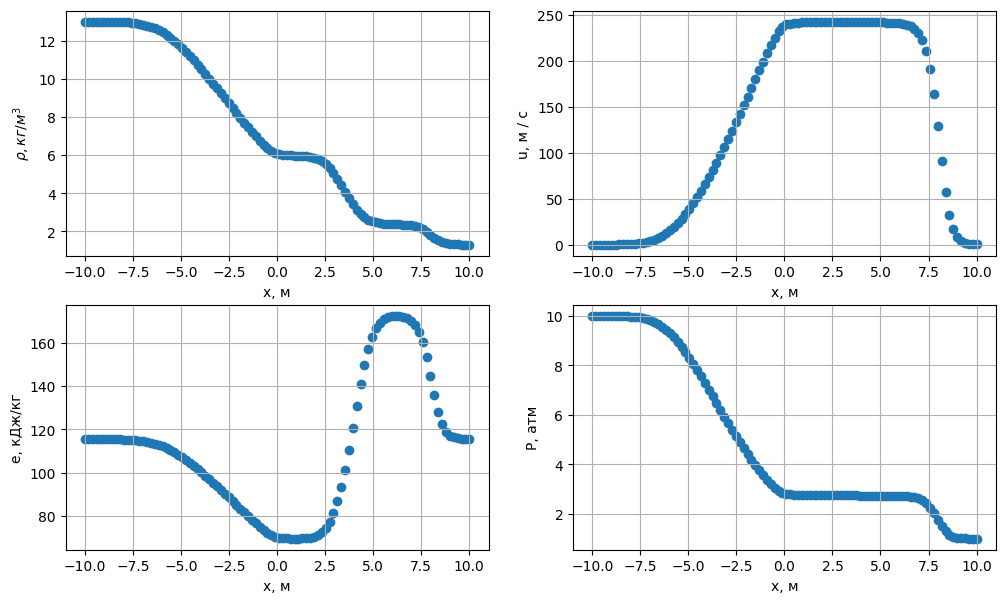

In [10]:
plt.figure(figsize=(12, 7))
# plt.title(f"t = {t_output:.2f}")

plt.subplot(2, 2, 1)
plt.scatter(x_grid, v_output[:,0])
plt.grid()
plt.xlabel("x, м")
plt.ylabel(r"$\rho, кг / м^3$")

plt.subplot(2, 2, 2)
plt.scatter(x_grid, v_output[:,1])
plt.grid()
plt.xlabel("x, м")
plt.ylabel(r"u, м / с")

plt.subplot(2, 2, 3)
plt.scatter(x_grid, v_output[:,2] / 1000)
plt.grid()
plt.xlabel("x, м")
plt.ylabel(r"e, кДж/кг")

plt.subplot(2, 2, 4)
plt.scatter(x_grid, P_output / 10 ** 5)
plt.grid()
plt.xlabel("x, м")
plt.ylabel(r"P, атм")

plt.savefig("task2.png")
print(f"t_output = {t_output}")